## 概览

zillionare通过omicron提供了行情数据、时间运算、基础算法、策略编写、回测等功能。在本环境中，自带了2022年全年的数据（从30分钟到周线）。

关于 omicron 的用法，请参见 https://zillionare.github.io/omicron


In [ ]:
import datetime
import logging
import sys
import warnings
from typing import Dict, List, Optional, Union

import cfg4py
import numpy as np
import omicron
import pandas as pd
import talib as ta
from coretypes import Frame, FrameType
from IPython.display import clear_output
from omicron import tf
from omicron.core.backtestlog import BacktestLogger
from omicron.extensions import (
    array_math_round,
    array_price_equal,
    bars_since,
    count_between,
    fill_nan,
    find_runs,
    math_round,
    price_equal,
    smallest_n_argpos,
    top_n_argpos,
)
from omicron.models.board import Board, BoardType
from omicron.models.security import Security
from omicron.models.stock import Stock
from omicron.plotting.candlestick import Candlestick
from omicron.plotting.metrics import MetricsGraph
from omicron.talib import moving_average
from traderclient import TraderClient

warnings.filterwarnings("ignore")
logger = BacktestLogger.getLogger("notebook")

cfg4py.init("/etc/zillionare")

await omicron.init()
Board.init("omega")

## 行情数据
### 个股行情

我们可以通过get_bars来获取行情数据。

In [7]:
bars = await Stock.get_bars("000001.XSHE", 250, FrameType.DAY)
bars[-10:]

array([('2023-01-30T00:00:00', 15.6 , 15.74, 14.89, 15.15, 1.37431750e+08, 2.09686765e+09, 123.90969),
       ('2023-01-31T00:00:00', 15.24, 15.51, 14.96, 14.99, 1.03049784e+08, 1.56863933e+09, 123.90969),
       ('2023-02-01T00:00:00', 15.03, 15.08, 14.51, 14.7 , 1.65342148e+08, 2.42647197e+09, 123.90969),
       ('2023-02-02T00:00:00', 14.74, 14.78, 14.27, 14.6 , 1.57790039e+08, 2.28074488e+09, 123.90969),
       ('2023-02-03T00:00:00', 14.45, 14.55, 14.16, 14.32, 1.24638298e+08, 1.78210589e+09, 123.90969),
       ('2023-02-06T00:00:00', 14.1 , 14.13, 13.86, 14.  , 1.31761010e+08, 1.83842871e+09, 123.90969),
       ('2023-02-07T00:00:00', 14.06, 14.32, 14.03, 14.21, 8.69460460e+07, 1.23529776e+09, 123.90969),
       ('2023-02-08T00:00:00', 14.24, 14.32, 14.03, 14.04, 6.57892570e+07, 9.28708934e+08, 123.90969),
       ('2023-02-09T00:00:00', 14.01, 14.3 , 13.96, 14.13, 8.30350020e+07, 1.17436196e+09, 123.90969),
       ('2023-02-10T00:00:00', 14.1 , 14.12, 13.86, 13.98, 8.47283660e+07

这样获取的数据是Numpy structured array数据结构。我们可以通过以下方法将其转换为pd.DataFrame

### 板块信息

In [38]:
from omicron.models.board import Board, BoardType

concepts = await Board.board_list()
concepts[:10]

df = pd.DataFrame(bars)
df[:10]

,frame,open,high,low,close,volume,amount,factor
0,2022-09-01,1077.703003,1080.427002,1066.473999,1067.234009,226989220.0,1.099670e+09,1.0
1,2022-09-02,1069.370972,1083.811035,1069.370972,1082.511963,236729820.0,1.258059e+09,1.0
2,2022-09-05,1080.014038,1091.135986,1077.687988,1090.916992,237900350.0,1.127750e+09,1.0
3,2022-09-06,1093.052979,1112.338013,1092.463013,1111.156982,260565040.0,1.407028e+09,1.0
4,2022-09-07,1108.711060,1114.146973,1100.338013,1109.458008,201213880.0,1.290435e+09,1.0
5,2022-09-08,1107.348999,1117.490967,1098.937012,1099.796021,293380040.0,1.352487e+09,1.0
6,2022-09-09,1096.170044,1103.285034,1087.983032,1100.604980,202762210.0,9.239262e+08,1.0
7,2022-09-13,1101.515015,1109.812012,1100.319946,1108.181030,179904920.0,1.017504e+09,1.0
8,2022-09-14,1092.937988,1094.963989,1080.584961,1088.295044,191233000.0,1.018259e+09,1.0
9,2022-09-15,1091.406982,1092.852051,1059.657959,1065.496948,251875980.0,1.458851e+09,1.0


### 获取板块行情

In [ ]:
start = datetime.date(2022, 9, 1)  # 起始时间， 可修改
end = datetime.date(2023, 3, 1)  # 截止时间， 可修改
board_code = '881128' # 汽车服务， 可修改
bars = await Board.get_bars_in_range(board_code, start, end)
bars[-3:] # 打印后3条数据

## 绘制K线图

我们可以通过 omicron.plotting.candlestick中的类 Candlestick 来绘制k线图：

[0.7, 0.15, 0.15]


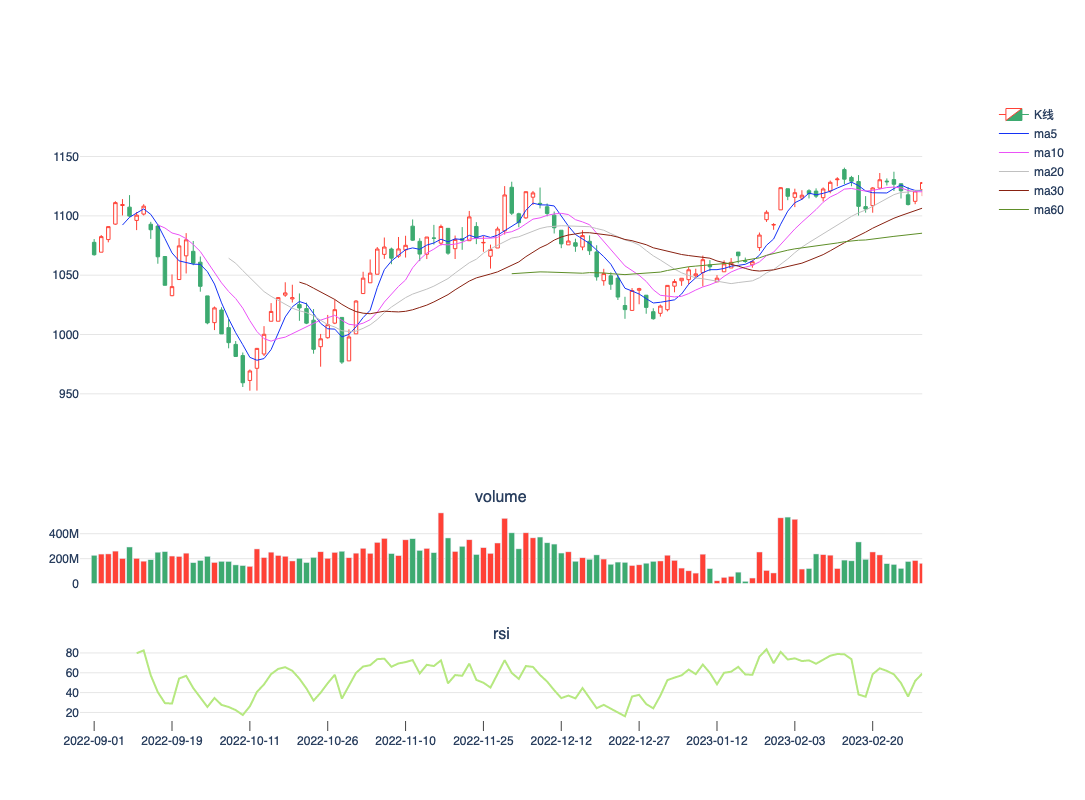

In [39]:
from omicron.plotting.candlestick import Candlestick

cs = Candlestick(bars, height=800)
cs.plot()

## 回测

您可以像omicron.strategy.sma.SMAStrategy策略一样，编写回测并执行（注意，在本环境下运行时，您需要事先补充分钟级数据）